In [1]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F
import math

## For visualization

import matplotlib.pyplot as plt

In [2]:
# Using GPU computing if available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:

'''
Step 1: Fashion MNIST
'''

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.ColorJitter(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./cifar_10data/',
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.FashionMNIST(root='./cifar_10data/',
                                train=False, 
                                transform=transforms.ToTensor())
    



Extracting ./cifar_10data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./cifar_10data/FashionMNIST/raw


Extracting ./cifar_10data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./cifar_10data/FashionMNIST/raw


Extracting ./cifar_10data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./cifar_10data/FashionMNIST/raw


Extracting ./cifar_10data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./cifar_10data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:

'''
Step 2 

In here, I construct LeNet, VGG, NiN, GoogLeNet, ResNet architectures to compare result.
Although the problem requires training just one of the last 4 architectures,
for the sake of studying code, I trained every model

'''

"""

Modern LeNet

"""
class LeNet(nn.Module) :

    # I maintain the architecture of the modern LeNet5 as the same as before.

    def __init__(self) :
        super(LeNet, self).__init__()
        p_drop = 0.1
        
        self.conv_layer1 = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, padding=2),
                nn.ReLU()
                )
        self.pool_layer1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5),
                nn.ReLU()
                )
        self.pool_layer2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.C5_layer = nn.Sequential(
                nn.Dropout2d(p=p_drop),
                nn.Linear(5*5*16, 120),
                nn.ReLU()
                )
        self.fc_layer1 = nn.Sequential(
                nn.Dropout2d(p=p_drop),
                nn.Linear(120, 84),
                nn.ReLU()
                )
        self.fc_layer2 = nn.Linear(84, 10)


    def forward(self, x) :
        output = self.conv_layer1(x)
        output = self.pool_layer1(output)
        output = self.conv_layer2(output)
        output = self.pool_layer2(output)
        output = output.view(-1,5*5*16)
        output = self.C5_layer(output)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        return output

"""

VGG8 (Modified)

"""

class VGG8(nn.Module) :
    def __init__(self) :
        super(VGG8, self).__init__()
        # 1 * 28 * 28
        self.conv_layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, padding=1),     # 16 * 28 * 28
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, padding=1),    # 16 * 28 * 28
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 16 * 14 * 14
                )
        self.conv_layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, padding=1),   # 32 * 14 * 14
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 32 * 14 * 14
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 32 * 7 * 7
                )
        self.conv_layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64 * 7 * 7
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 64 * 7 * 7
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 64 * 3 * 3
                )
        self.fc_layer1 = nn.Sequential(
                nn.Dropout(),
                nn.Linear(576, 128),                          # 1 * 128
                nn.ReLU()
                )
        self.fc_layer2 = nn.Sequential(
                nn.Linear(128, 10),                     # 1 * num_class
                )

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
        
    def forward(self, x) :
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = output.view(-1, 64*3*3)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        return output
                             
    
'''

NiN Model 

'''

class NiN(nn.Module) :
    def __init__(self) :
        super(NiN, self).__init__()
        
        # I reduce the number of channles for the sake of computation

        # Attributes of NiN 
        # It does not affect the spatial dimension(maintain the spatial dimension) 
        # You only need to be careful when MaxPooling is applied(it only affects the spatial dimension)
        self.mlpconv_layer1 = nn.Sequential(                   # Output dimension/ parameters number   
                nn.Conv2d(1, 32, kernel_size=5, padding=2),    # 32 * 28 * 28 / (5*5*1+1)*32
                nn.ReLU(),
                nn.Conv2d(32, 16, kernel_size=1),              # 16 * 28 * 28 / (1*1*32+1)*16
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=1),              # 32 * 28 * 28 / (1*1*32+1)*16
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),#  32 * 14 * 14 / None
                # Note on spatial dimension: (Input - Kernel_size + 2*padding_size) / stride + 1 =
                # (28 - 3 + 2*1) / 2 + 1 = 14 (round down: floor mode)
                # the number of channels is kept the same (32)
                nn.Dropout()
                )
        self.mlpconv_layer2 = nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=5, padding=2),   # 32 * 14 * 14 / (5*5*32+1)*32
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=1),             # 32 * 14 * 14 / (1*1*32+1)*32
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=1),             # 32 * 14 * 14 / (1*1*32+1)*32
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),# 32 * 7 * 7 / None
                nn.Dropout()
                )
        self.mlpconv_layer3 = nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 32 * 7 * 7/ (5*5*32+1)*32
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=1),             # 32 * 7 * 7  / (1*1*32+1)*32
                nn.ReLU(),
                nn.Conv2d(32, 10, kernel_size=1),              # 10 * 7 * 7  / (1*1*32+1)*10
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=7)                     # 10 * 1 * 1 / None
                # Kernel_size = spatial dimension(width=height) => Global Average
                )
        
    
    def forward(self, x) :
        output = self.mlpconv_layer1(x)
        output = self.mlpconv_layer2(output)
        output = self.mlpconv_layer3(output)
        output = output.view(-1, 10) # for the classification
        return output



'''

GoogLeNet Model 

'''



class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()        

        self.conv1 = BasicConv2d(1, 32, kernel_size=7, padding=3)
        self.conv2 = BasicConv2d(32, 32, kernel_size=1)
        self.conv3 = BasicConv2d(32, 64, kernel_size=5)  #NOTE f=5 needed, not f=4 as incorrectly said in lecture

        # Note that spatial dimension of an image is not important for incemption module
        # Since the inception module maintains spatial dimension.
        self.inception3 = Inception(64, 16, 16, 16, 16, 16, 16)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True) # ceil_mode=True to keep spatial dimension


        # Reduce the number of layers for the computation
        self.inception4 = Inception(64, 8, 32, 64, 16, 32, 24)

        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5 = Inception(128, 128, 32, 64, 32, 32, 32)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # taking average indep on a channel 
        # i.e. for given channel, we just take average over spatial dimension
        # so, the kernel size of conv1,2,3 does not affect the resulting dimension for the next Fully connected layer
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 10)
        
        for m in self.modules(): # Xavier initialization
            # For each module, apply xavier_uniform_(m.weight) initialization
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # N x 1 x 28 x 28
        x = self.conv1(x)
        # N x 32 x 28 x 28
        x = self.conv2(x)
        # N x 32 x 28 x 28
        x = self.conv3(x)
        # N x 64 x 24 x 24
        x = self.inception3(x)
        # N x 64 x 24 x 24
        x = self.maxpool3(x)
        # N x 64 x 11 x 11
        x = self.inception4(x)
        # N x 128 x 11 x 11
        x = self.maxpool4(x)
        # N x 128 x 4 x 4
        x = self.inception5(x)

        # N x 256 x 4 x 4
        x = self.avgpool(x)
        # N x 256 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 256
        x = self.dropout(x)
        x = self.fc(x)
        # N x 10 (num_classes)
        return x

class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        # Need to specify 'channels' of each branch
        # 4 branches 

        super(Inception, self).__init__()
        
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1) # concatenating all branches


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, **kwargs),
                            nn.ReLU()
                            )
    def forward(self, x):
        return self.conv(x)

'''

ResNet

'''
class BasicBlock(nn.Module):
    expansion = 1 # Do not need to expand 
    # Because without bottleneck, ResNet keeps the number of channels

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4 # It requires expansion

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        # 1 * 1 bottleneck convlotuions
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [6]:

'''
Step 3
'''

model_LeNet = LeNet().to(device)
model_VGG8 = VGG8().to(device)
# model_NiN = NiN().to(device)
model_GoogLeNet = GoogLeNet().to(device)
model_ResNet = ResNet18().to(device)

loss_function = torch.nn.CrossEntropyLoss()


# Use Adam for defualt optimizer
optimizer_LeNet = torch.optim.Adam(model_LeNet.parameters(), lr=0.01, weight_decay=1e-05)
optimizer_VGG8 = torch.optim.Adam(model_VGG8.parameters(), lr=0.01, weight_decay=1e-05)
# optimizer_NiN = torch.optim.Adam(model_NiN.parameters(), lr=0.01, weight_decay=1e-05)
optimizer_GoogLeNet = torch.optim.Adam(model_GoogLeNet.parameters(), lr=0.01, weight_decay=1e-05)
optimizer_ResNet = torch.optim.Adam(model_ResNet.parameters(), lr=0.01, weight_decay=1e-05)


In [7]:

'''

Step 4

'''
model_LeNet.train()
model_VGG8.train()
# model_NiN.train()
model_GoogLeNet.train()
model_ResNet.train()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=True) # Random Reshuffled SGD

import time
start = time.time()
for epoch in range(50) :
    print("{}th epoch starting.".format(epoch))
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)

        optimizer_LeNet.zero_grad()
        optimizer_VGG8.zero_grad()
        # optimizer_NiN.zero_grad()
        optimizer_GoogLeNet.zero_grad()
        optimizer_ResNet.zero_grad()

        train_loss_LeNet = loss_function(model_LeNet(images), labels)
        train_loss_VGG8 = loss_function(model_VGG8(images), labels)
        # train_loss_NiN = loss_function(model_NiN(images), labels)
        train_loss_GoogLeNet = loss_function(model_GoogLeNet(images), labels)
        train_loss_ResNet = loss_function(model_ResNet(images), labels)

        train_loss_LeNet.backward()
        train_loss_VGG8.backward()
        # train_loss_NiN.backward()
        train_loss_GoogLeNet.backward()
        train_loss_ResNet.backward()

        optimizer_LeNet.step()
        optimizer_VGG8.step()
        # optimizer_NiN.step()
        optimizer_GoogLeNet.step()
        optimizer_ResNet.step()

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


0th epoch starting.
1th epoch starting.
2th epoch starting.
3th epoch starting.
4th epoch starting.
5th epoch starting.
6th epoch starting.
7th epoch starting.
8th epoch starting.
9th epoch starting.
10th epoch starting.
11th epoch starting.
12th epoch starting.
13th epoch starting.
14th epoch starting.
15th epoch starting.
16th epoch starting.
17th epoch starting.
18th epoch starting.
19th epoch starting.
20th epoch starting.
21th epoch starting.
22th epoch starting.
23th epoch starting.
24th epoch starting.
25th epoch starting.
26th epoch starting.
27th epoch starting.
28th epoch starting.
29th epoch starting.
30th epoch starting.
31th epoch starting.
32th epoch starting.
33th epoch starting.
34th epoch starting.
35th epoch starting.
36th epoch starting.
37th epoch starting.
38th epoch starting.
39th epoch starting.
40th epoch starting.
41th epoch starting.
42th epoch starting.
43th epoch starting.
44th epoch starting.
45th epoch starting.
46th epoch starting.
47th epoch starting.
48

In [13]:

'''
Step 5
'''

model_LeNet.eval()
model_VGG8.eval()
# model_NiN.eval()
model_GoogLeNet.eval()
model_ResNet.eval()

test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle = False)

models = [model_LeNet, model_VGG8, model_GoogLeNet,model_ResNet]

models_name = ["model_LeNet", "model_VGG8", "model_GoogLeNet","model_ResNet"]     

correct_ind_models = []
missed_ind = []
missed_label = []
i = 0
for model in models:    
    test_loss, correct, total = 0, 0, 0    
    correct_ind_by_model = []
    missed_ind_by_model = []
    missed_label_by_model = []
    with torch.no_grad():  #using context manager    
        for idx, (images, labels) in enumerate(test_loader) :
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += loss_function(output, labels).item()

            pred = output.max(1, keepdim=True)[1]
            correct_indicator = pred.eq(labels.view_as(pred)).item()
            if correct_indicator == 1 : 
                correct += correct_indicator
                correct_ind_by_model += [idx]

            else :            
                missed_ind_by_model += [idx]
                missed_label_by_model.append(pred)

        
          
            total += labels.size(0)
      
    print('The Performance of ' + models_name[i] + ":")
    print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss /total, correct, total,
            100. * correct / total))
    correct_ind_models.append(correct_ind_by_model)
    missed_ind.append(missed_ind_by_model)
    missed_label.append(missed_label_by_model)
    i += 1


The Performance of model_LeNet:
[Test set] Average loss: 0.2948, Accuracy: 8972/10000 (89.72%)

The Performance of model_VGG8:
[Test set] Average loss: 0.2656, Accuracy: 9029/10000 (90.29%)

The Performance of model_GoogLeNet:
[Test set] Average loss: 0.2398, Accuracy: 9160/10000 (91.60%)

The Performance of model_ResNet:
[Test set] Average loss: 0.3632, Accuracy: 9166/10000 (91.66%)



In [14]:
"""

Every model seems to have similar performance.
The best performance was done by ResNet
A notable thing is that all "deep" models performed better than the LeNet archtecture.

"""

'\n\nEvery model seems to have similar performance.\nThe best performance was done by ResNet\nA notable thing is that all "deep" models performed better than the LeNet archtecture.\n\n'

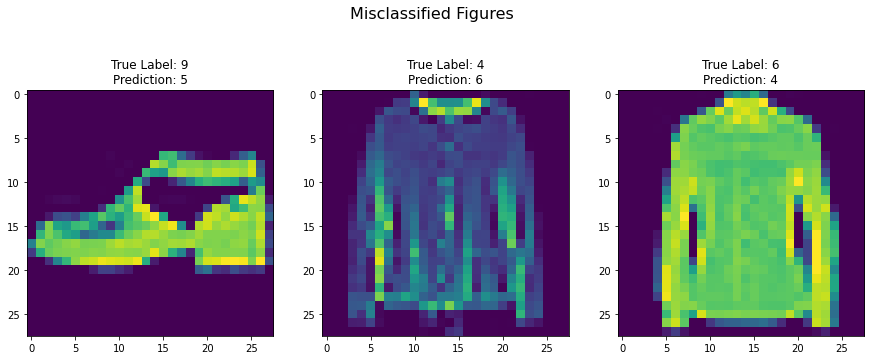

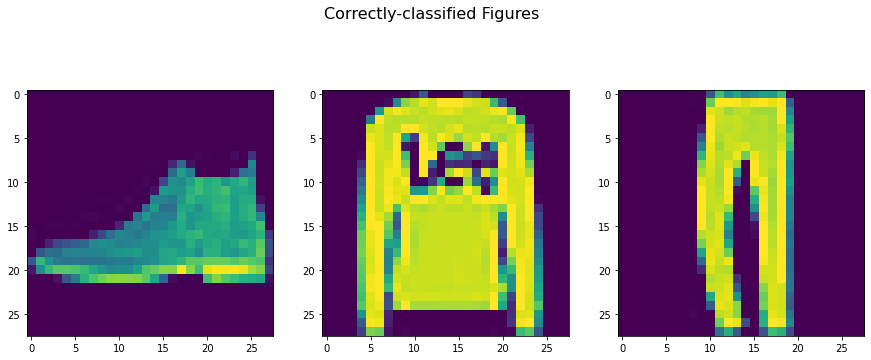

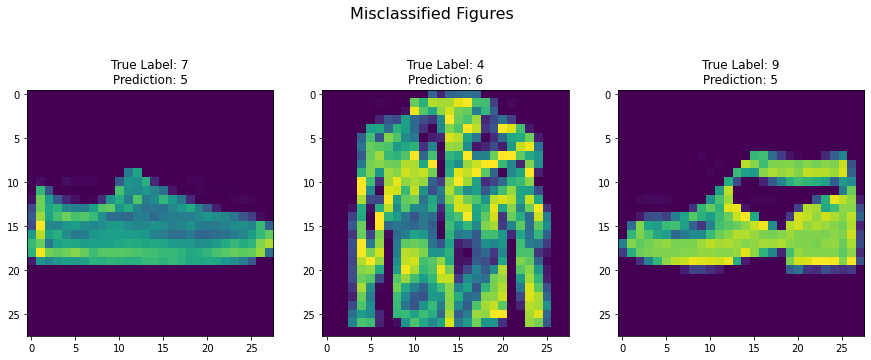

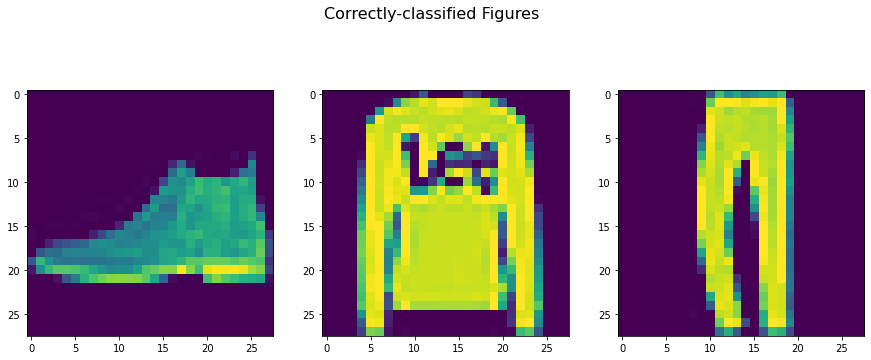

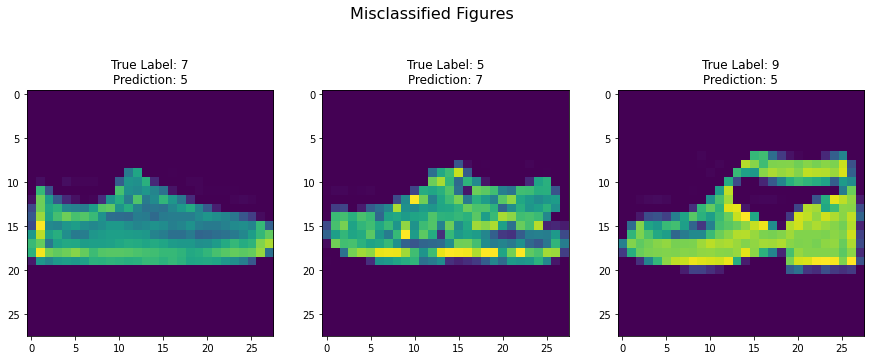

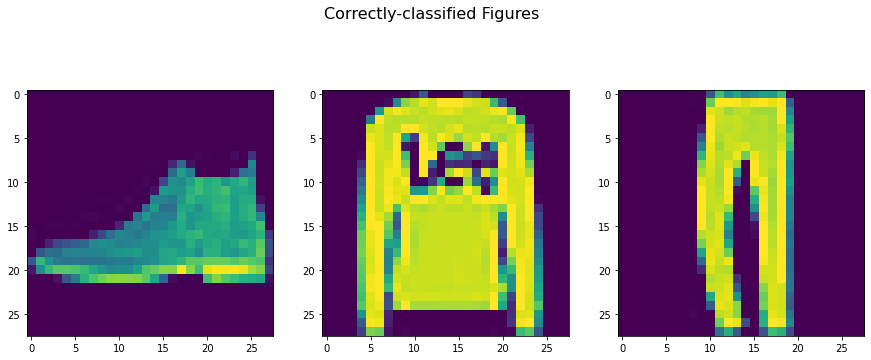

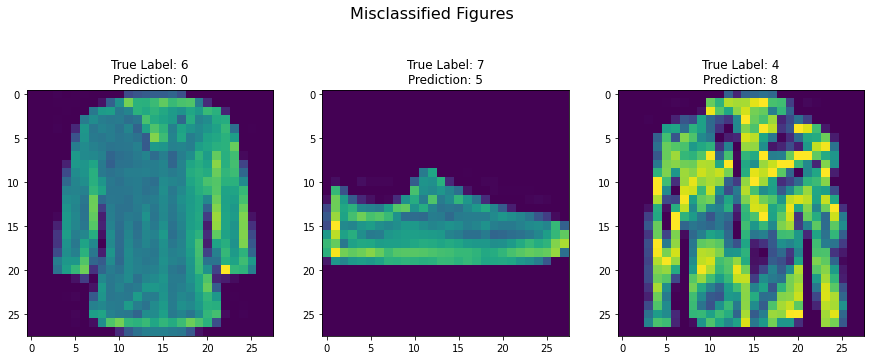

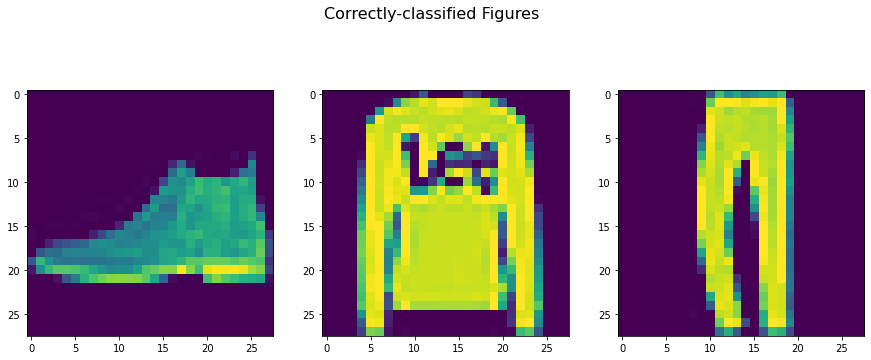

In [15]:
# Step 6

for model_number in range(len(missed_ind)):
  misclassified_ind = missed_ind[model_number]
  misclassified_label = missed_label[model_number]
  # Misclassified images
  fig = plt.figure(1, figsize=(15, 6))
  fig.suptitle('Misclassified Figures', fontsize=16)

  for k in range(3) :
      image = test_dataset.data[misclassified_ind[k]].cpu().numpy().astype('uint8')
      ax = fig.add_subplot(1, 3, k+1)
      true_label = test_dataset.targets[misclassified_ind[k]]
      
      ax.set_title('True Label: {}\nPrediction: {}'.format(true_label, misclassified_label[k].item()))
      plt.imshow(image)
  plt.show()


  correct_ind = correct_ind_models[model_number]
  # Correctly classified images
  fig = plt.figure(2, figsize=(15, 6))
  fig.suptitle('Correctly-classified Figures', fontsize=16)
  for k in range(3) :
      image = test_dataset.data[correct_ind[k]].cpu().numpy().astype('uint8')
      ax = fig.add_subplot(1, 3, k+1)
      true_label = test_dataset.targets[correct_ind[k]]
      plt.imshow(image)
  plt.show()

In [16]:
## All models seem to have classifiying "boots"
## Jeans and T-shirts are fairly well classified